<a href="https://colab.research.google.com/github/shainaraza/BERT/blob/master/Text_Classification_longformer_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import json, re
from tqdm import tqdm_notebook
from uuid import uuid4

## Torch Modules
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader


## Mount Drive into Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install transformers

     |████████████████████████████████| 1.1MB 4.6MB/s 
     |████████████████████████████████| 890kB 23.3MB/s 
     |████████████████████████████████| 3.0MB 15.2MB/s 
     |████████████████████████████████| 1.1MB 43.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=fb4779d4dcdc5bd05e302e2da9c4696d1251497c2e16f8fe4b817647253369f6
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [14]:
## PyTorch Transformer
from transformers import LongformerModel, LongformerTokenizer
from transformers import LongformerForSequenceClassification, LongformerConfig

In [15]:
## Check if Cuda is Available
print(torch.cuda.is_available())

True


In [ ]:
## Install PyTorch-Transformer

In [ ]:
#!pip install -U pytorch-transformers

In [ ]:
## Importing Datasets

In [6]:
import pandas as pd
train1=pd.read_csv('/content/drive/My Drive/FAKENEWSDETECTION_Shaina/nela.tsv', encoding='utf-8', header=None,index_col=None)

In [17]:
dataset = pd.DataFrame(columns = ['content', 'label'])
texts = []
dataset['content']=train1[5]
dataset['label']=train1[3]
dataset['content']=dataset.replace('\n','', regex=True)
    
dataset.tail()
dataset1=dataset.sample(n=1000, random_state=1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9c2d4132b0>]],
      dtype=object)

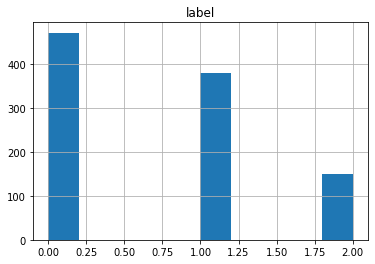

In [18]:
dataset1.hist(['label'])


In [19]:
tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')

#length of comments
import numpy as np
input_ids=[]
lengths=[]
for sent in dataset1['content']:
   encode_sent=tokenizer.encode(sent,add_special_tokens=True) #encoding and adding special tokens [cls],[sep]
   input_ids.append(encode_sent)
   lengths.append(len(encode_sent))
print('min_length',min(lengths))
print('max_lengths',max(lengths))
print('median_lengths',np.median(lengths))

Token indices sequence length is longer than the specified maximum sequence length for this model (8725 > 4096). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (7362 > 4096). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4435 > 4096). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5236 > 4096). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5149 > 4096). Running this sequence through the model will result in indexing errors


min_length 22
max_lengths 8725
median_lengths 538.0


In [20]:
label_to_ix = {}
for label in dataset.label:
   if label not in label_to_ix:
      label_to_ix[label]=len(label_to_ix)
label_to_ix

{0: 0, 1: 2, 2: 1}

In [21]:
config = {
  "model_name" : 'allenai/longformer-base-4096',
  "model_name_or_path": 'allenai/longformer-base-4096',
  "max_seq_length": 1024 ,
  "output_dir": './models',
  "overwrite_output_dir": True,
  "per_gpu_train_batch_size": 4,
  "per_gpu_eval_batch_size": 4,
#   "gradient_accumulation_steps": 16,
  "overwrite_cache": True,
  "learning_rate": 1e-4,
  "num_train_epochs": 3,
  "do_train": True,
  "do_eval" : True,
  "save_steps": 5000,
  "save_total_limit": 2,
}

In [22]:
config = LongformerConfig.from_pretrained('allenai/longformer-base-4096',config=config)
config.num_labels = len(list(label_to_ix.values()))

config

LongformerConfig {
  "attention_mode": "longformer",
  "attention_probs_dropout_prob": 0.1,
  "attention_window": [
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512
  ],
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "ignore_attention_mask": false,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 4098,
  "model_type": "longformer",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "sep_token_id": 2,
  "type_vocab_size": 1,
  "vocab_size": 50265
}

In [23]:
tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')
model = LongformerForSequenceClassification(config)

In [24]:
import torch, gc

torch.cuda.empty_cache()

!nvidia-smi


Tue Oct 13 16:05:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |     10MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
## Feature Preparation

In [25]:
def prepare_features(seq_1, max_seq_length = 1000, 
             zero_pad = False, include_CLS_token = True, include_SEP_token = True):
    ## Tokenzine Input
    tokens_a = tokenizer.tokenize(seq_1)

    ## Truncate
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0:(max_seq_length - 2)]
    ## Initialize Tokens
    tokens = []
    if include_CLS_token:
        tokens.append(tokenizer.cls_token)
    ## Add Tokens and separators
    for token in tokens_a:
        tokens.append(token)

    if include_SEP_token:
        tokens.append(tokenizer.sep_token)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    ## Input Mask 
    input_mask = [1] * len(input_ids)
    ## Zero-pad sequence lenght
    if zero_pad:
        while len(input_ids) < max_seq_length:
            input_ids.append(0)
            input_mask.append(0)
    return torch.tensor(input_ids).unsqueeze(0), input_mask

In [26]:
msg = "My dog is cute!"
prepare_features(msg)

(tensor([[    0,  2387,  2335,    16, 11962,   328,     2]]),
 [1, 1, 1, 1, 1, 1, 1])

In [ ]:
## Dataset Loader Classes

In [27]:
class Intents(Dataset):
    def __init__(self, dataframe):
        self.len = len(dataframe)
        self.data = dataframe
        
    def __getitem__(self, index):
        content = self.data.content[index]
        label = self.data.label[index]
        X, _  = prepare_features(content)
        y = label_to_ix[self.data.label[index]]
        return X, y
    
    def __len__(self):
        return self.len

In [28]:
max(dataset1.label)

2

In [29]:
train_size = 0.8
train_dataset=dataset1.sample(frac=train_size,random_state=200)
test_dataset=dataset1.drop(train_dataset.index).reset_index(drop=True)
train_dataset=train_dataset.reset_index(drop=True)
#drop(train_dataset.index)

In [30]:
print("FULL Dataset: {}".format(dataset1.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

FULL Dataset: (1000, 2)
TRAIN Dataset: (800, 2)
TEST Dataset: (200, 2)


In [31]:
training_set = Intents(train_dataset)
testing_set = Intents(test_dataset)

In [32]:
training_set.__getitem__(0)[0].shape

torch.Size([1, 859])

In [33]:
model(training_set.__getitem__(0)[0])

(tensor([[0.0570, 0.1871, 0.1467]], grad_fn=<AddmmBackward>),)

In [ ]:
## Training Params

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.cuda()

In [35]:
# Parameters
params = {'batch_size': 1,
          'shuffle': True,
          'drop_last': False,
          'num_workers': 1}

In [36]:
training_loader = DataLoader(training_set, **params)
testing_loader = DataLoader(testing_set, **params)

In [37]:
loss_function = nn.CrossEntropyLoss()
learning_rate = 1e-05
optimizer = optim.Adam(params =  model.parameters(), lr=learning_rate)

In [38]:
## Test Forward Pass
inp = training_set.__getitem__(0)[0].cuda()
output = model(inp)[0]
print(output.shape)

torch.Size([1, 3])


In [39]:
torch.__version__

'1.6.0+cu101'

In [ ]:
max_epochs = 10
model = model.train()
for epoch in tqdm_notebook(range(max_epochs)):
    print("EPOCH -- {}".format(epoch))
    for i, (sent, label) in enumerate(training_loader):
        optimizer.zero_grad()
        sent = sent.squeeze(0)
        if torch.cuda.is_available():
          sent = sent.cuda()
          label = label.cuda()
        output = model.forward(sent)[0]
        _, predicted = torch.max(output, 1)
        
        loss = loss_function(output, label)
        loss.backward()
        optimizer.step()
        
        if i%100 == 0:
            correct = 0
            total = 0
            for sent, label in testing_loader:
                sent = sent.squeeze(0)
                if torch.cuda.is_available():
                  sent = sent.cuda()
                  label = label.cuda()
                output = model.forward(sent)[0]
                _, predicted = torch.max(output.data, 1)
                total += label.size(0)
                correct += (predicted.cpu() == label.cpu()).sum()
            accuracy = 100.00 * correct.numpy() / total
            print('Iteration: {}. Loss: {}. Accuracy: {}%'.format(i, loss.item(), accuracy))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


EPOCH -- 0
Iteration: 0. Loss: 0.6085115075111389. Accuracy: 50.5%
Iteration: 100. Loss: 0.800544023513794. Accuracy: 42.0%
Iteration: 200. Loss: 1.1217069625854492. Accuracy: 52.0%
Iteration: 300. Loss: 1.0271412134170532. Accuracy: 52.0%
Iteration: 400. Loss: 0.706067681312561. Accuracy: 38.0%
Iteration: 500. Loss: 0.7701405882835388. Accuracy: 53.0%
Iteration: 600. Loss: 1.9862873554229736. Accuracy: 43.0%
Iteration: 700. Loss: 1.79661226272583. Accuracy: 52.5%
EPOCH -- 1
Iteration: 0. Loss: 0.8224081993103027. Accuracy: 50.0%
Iteration: 100. Loss: 0.6317182183265686. Accuracy: 50.0%
Iteration: 200. Loss: 0.8896462917327881. Accuracy: 30.0%
Iteration: 300. Loss: 1.2325459718704224. Accuracy: 32.5%
Iteration: 400. Loss: 1.1418039798736572. Accuracy: 48.5%
Iteration: 500. Loss: 2.267909049987793. Accuracy: 38.0%
Iteration: 600. Loss: 0.643364667892456. Accuracy: 45.5%
Iteration: 700. Loss: 1.8026046752929688. Accuracy: 34.5%
EPOCH -- 2
Iteration: 0. Loss: 0.48238635063171387. Accuracy

In [41]:
 torch.save(model.state_dict(), './roberta_state_dict_'+ str(uuid4())+'.pth')

In [42]:
dataset1.tail(5)

,content,label
298542,Trump Says Homeless People Are Making Cops Sic...,0
282451,OMAR 2015: Somalia ‘our nation back home’ (VID...,2
269490,Yankees humiliated by Red Sox as Masahiro Tana...,1
633847,Championship rivals want West Brom fringe man ...,1
490980,"Holi 2019: When is the festival, what is its s...",0


In [ ]:
## Load model

In [44]:
model_path = '/content/roberta_state_dict_05ae5660-2a8e-4f13-bc4a-c0a0b2fc15cb.pth'

In [45]:
model.save_pretrained('./mod')

In [46]:
model.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

In [47]:
model.from_pretrained('./mod', return_dict=True)

LongformerForSequenceClassification(
  (longformer): LongformerModel(
    (embeddings): LongformerEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(4098, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LongformerEncoder(
      (layer): ModuleList(
        (0): LongformerLayer(
          (attention): LongformerAttention(
            (self): LongformerSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (query_global): Linear(in_features=768, out_features=768, bias=True)
              (key_global): Linear(in_features=768, out_features=768, bias=True)
              (val

In [48]:
label_to_ix.keys()

dict_keys([0, 2, 1])

In [49]:
def get_reply(msg):
  model.eval()
  input_msg, _ = prepare_features(msg)
  if torch.cuda.is_available():
    input_msg = input_msg.cuda()
  output = model(input_msg)[0]
  _, pred_label = torch.max(output.data, 1)
  prediction=list(label_to_ix.keys())[pred_label]
  return prediction



In [51]:
get_reply("Trump Says Homeless People Are Making Cops")

0

In [52]:
get_reply("Championship rivals want West Brom fringe")

0

In [53]:
get_reply("low humidity, high altitude")

0

In [54]:
get_reply("Book tacos for me tonight")

0

In [55]:
get_reply("Book a table for me tonight")

0

In [ ]:
get_reply("there us no way onion")